In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import numpy as np
import gc
from natsort import index_natsorted
np.random.seed(12)

def load_methylation(file):
    names = ['chrom','start','stop','name','methylation', 'window_chrom',
             'window_start', 'window_stop', 'window_name', 'window_dot']
    binned_df = pd.read_csv(file, sep='\t', header=None, names=names,
                            dtype={'chrom':str,
                                   'window_chrom':str})

    binned_df = binned_df[~binned_df['chrom'].str.startswith('mat')]

    return binned_df

In [ ]:
# Load the methylation bed file
# tuwa_pb = pd.read_csv('../methylation/TuWa_PB.combined.bed', sep='\t',
#                       header=None,
#                       dtype={0:str})
window = '100kb'
step = '50kb'

# Load files that have median methylation for $window sized windows and $step sized steps.
# TUWA_ONT = f"/path/to/methylation/UOA_Wagyu_1.withY.{window}Win.{step}Step.ONT.bed.gz"
# TUWA_PB = f"/path/to/methylation/UOA_Wagyu_1.withY.{window}Win.{step}Step.PB.bed.gz"

tuwa_ont = load_methylation(TUWA_ONT)
tuwa_pb = load_methylation(TUWA_PB)

# Load the bed windows used to generate TUWA_ONT / TUWA_PB
# WINDOWS = f"/path/to/methylation/UOA_Wagyu_1.withY.{window}Win.{step}Step.bed.gz"
windows = pd.read_csv(WINDOWS,
                      sep='\t', header=None)

windows


,0,1,2,3,4
0,1,0,100000,1_1,.
1,1,50000,150000,1_2,.
2,1,100000,200000,1_3,.
3,1,150000,250000,1_4,.
4,1,200000,300000,1_5,.
...,...,...,...,...,...
64203,Y,59200000,59300000,Y_1185,.
64204,Y,59250000,59350000,Y_1186,.
64205,Y,59300000,59400000,Y_1187,.
64206,Y,59350000,59450000,Y_1188,.


In [ ]:
# Load centromere regions
CENTROMERES = "/path/to/wagyu_centromere_locations.txt"
centromeres = pd.read_csv(CENTROMERES,
                          sep='\t', names=['chromosome','start','end'])
centromeres.head()

# Round to nearest 1Mb
centromeres['Rounded_Start'] = centromeres['start'].apply(lambda x: x - x % 1000000)
centromeres['Rounded_Stop'] = centromeres['end'].apply(lambda x: x - x % 1000000)
centromeres

,chromosome,start,end,Rounded_Start,Rounded_Stop
0,1,0,21927941,0,21000000
1,2,3078,9146847,0,9000000
2,3,0,19091097,0,19000000
3,4,9405,16562382,0,16000000
4,5,0,11583385,0,11000000
5,6,0,15507068,0,15000000
6,7,0,15252090,0,15000000
7,8,0,13181342,0,13000000
8,9,25106,23824845,0,23000000
9,10,11414,14490847,0,14000000


In [ ]:
centromere_dict = {}
for row in windows.itertuples():
    if row[1] == '20':
        continue
    if row[1].lower().startswith('m'):
        continue

    chrom_centromere = centromeres[centromeres['chromosome'] == str(row[1])]

    try:
        centro_start = chrom_centromere['Rounded_Start'].values[0]
    except IndexError:
        print(row)
        break
    centro_end = chrom_centromere['Rounded_Stop'].values[0]

    if str(row[1]) == str(chrom_centromere['chromosome'].values[0]):
        if row._2 >= centro_start and row._3 <= centro_end:
            centromere_dict[row._4] = True


In [ ]:
# Group by window name and take the median for each window
tuwa_ont_grouped = tuwa_ont.groupby('window_name').agg({'methylation':'median'}).reset_index().rename(columns={'methylation':'median_methylation'})
tuwa_ont_grouped['region'] = tuwa_ont_grouped['window_name'].apply(lambda x: 'centromere' if centromere_dict.get(x) else 'non-centromere')
tuwa_ont_grouped['tech'] = 'ONT'
tuwa_ont_grouped['chromosome'] = tuwa_ont_grouped['window_name'].str.split('_').str[0]

tuwa_pb_grouped = tuwa_pb.groupby('window_name').agg({'methylation':'median'}).reset_index().rename(columns={'methylation':'median_methylation'})
tuwa_pb_grouped['region'] = tuwa_pb_grouped['window_name'].apply(lambda x: 'centromere' if centromere_dict.get(x) else 'non-centromere')
tuwa_pb_grouped['tech'] = 'PacBio'
tuwa_pb_grouped['chromosome'] = tuwa_pb_grouped['window_name'].str.split('_').str[0]

# Merge the ONT and PacBio dataframes

tuwa_meth_df = pd.concat([tuwa_ont_grouped, tuwa_pb_grouped])
del tuwa_ont_grouped, tuwa_pb_grouped
gc.collect()

# Filter out the mitochondrial and chromosome 20
tuwa_meth_df = tuwa_meth_df[tuwa_meth_df['chromosome'] != 'MT']
tuwa_meth_df = tuwa_meth_df[tuwa_meth_df['chromosome'] != '20']

tuwa_meth_df = tuwa_meth_df.sort_values(by='chromosome', key=lambda x: np.argsort(index_natsorted(tuwa_meth_df['chromosome'])))
# tuwa_meth_df = tuwa_meth_df.sort_values(by='window_name', key=lambda x: np.argsort(index_natsorted(tuwa_meth_df['window_name'])))
tuwa_meth_df

,window_name,median_methylation,region,tech,chromosome
18883,1_1,81.82,centromere,ONT,1
18884,1_10,87.50,centromere,ONT,1
18885,1_100,89.66,centromere,ONT,1
18886,1_1000,91.03,non-centromere,ONT,1
18887,1_1001,90.91,non-centromere,ONT,1
...,...,...,...,...,...
61008,Y_991,86.00,non-centromere,PacBio,Y
61009,Y_992,86.55,non-centromere,PacBio,Y
61010,Y_993,87.00,non-centromere,PacBio,Y
61011,Y_994,86.85,non-centromere,PacBio,Y


In [ ]:
chromosome = []
ont_significance = []
pb_significance = []


pvalue_dict = {'chromosome':[],
               'tech':[],
               'centromere_median':[],
               'non_centromere_median':[],
               'pvalue':[],
               'adjusted_pvalue':[]}

# Loop through the chromosomes and compare the methylation levels
for chrom in tqdm(tuwa_meth_df['chromosome'].unique()):
    if chrom == '20':
        continue

    ont_chrom_df = tuwa_meth_df[(tuwa_meth_df['chromosome'] == chrom) & (tuwa_meth_df['tech'] == 'ONT')]
    pb_chrom_df = tuwa_meth_df[(tuwa_meth_df['chromosome'] == chrom) & (tuwa_meth_df['tech'] == 'PacBio')]

    ont_c = ont_chrom_df[ont_chrom_df['region'] == 'centromere']['median_methylation']
    ont_nc = ont_chrom_df[ont_chrom_df['region'] == 'non-centromere']['median_methylation']

    pb_c = pb_chrom_df[pb_chrom_df['region'] == 'centromere']['median_methylation']
    pc_nc = pb_chrom_df[pb_chrom_df['region'] == 'non-centromere']['median_methylation']

    try:
        ont_pvalue = mannwhitneyu(ont_c, ont_nc).pvalue
    except ValueError:
        ont_pvalue = 1.

    try:
        pb_pvalue = mannwhitneyu(pb_c, pc_nc).pvalue
    except ValueError:
        pb_pvalue = 1.

    chromosome.append(chrom)
    ont_significance.append(ont_pvalue)
    pb_significance.append(pb_pvalue)

    pvalue_dict['chromosome'].append(chrom)
    pvalue_dict['tech'].append('ONT')
    pvalue_dict['centromere_median'].append(ont_c.median())
    pvalue_dict['non_centromere_median'].append(ont_nc.median())
    pvalue_dict['pvalue'].append(ont_pvalue)

    pvalue_dict['chromosome'].append(chrom)
    pvalue_dict['tech'].append('PacBio')
    pvalue_dict['centromere_median'].append(pb_c.median())
    pvalue_dict['non_centromere_median'].append(pc_nc.median())
    pvalue_dict['pvalue'].append(pb_pvalue)


genome_wide_ont = mannwhitneyu(
    x=tuwa_meth_df[(tuwa_meth_df['tech'] == 'ONT') & (tuwa_meth_df['region'] == 'centromere')]['median_methylation'],
    y=tuwa_meth_df[(tuwa_meth_df['tech'] == 'ONT') & (tuwa_meth_df['region'] == 'non-centromere')]['median_methylation']).pvalue

genome_wide_pb = mannwhitneyu(
    x=tuwa_meth_df[(tuwa_meth_df['tech'] == 'PacBio') & (tuwa_meth_df['region'] == 'centromere')]['median_methylation'],
    y=tuwa_meth_df[(tuwa_meth_df['tech'] == 'PacBio') & (tuwa_meth_df['region'] == 'non-centromere')]['median_methylation']).pvalue

pvalue_dict['chromosome'].append('Genome-wide')
pvalue_dict['tech'].append('ONT')
pvalue_dict['centromere_median'].append(tuwa_meth_df[(tuwa_meth_df['tech'] == 'ONT') & (tuwa_meth_df['region'] == 'centromere')]['median_methylation'].median())
pvalue_dict['non_centromere_median'].append(tuwa_meth_df[(tuwa_meth_df['tech'] == 'ONT') & (tuwa_meth_df['region'] == 'non-centromere')]['median_methylation'].median())
pvalue_dict['pvalue'].append(genome_wide_ont)

pvalue_dict['chromosome'].append('Genome-wide')
pvalue_dict['tech'].append('PacBio')
pvalue_dict['centromere_median'].append(tuwa_meth_df[(tuwa_meth_df['tech'] == 'PacBio') & (tuwa_meth_df['region'] == 'centromere')]['median_methylation'].median())
pvalue_dict['non_centromere_median'].append(tuwa_meth_df[(tuwa_meth_df['tech'] == 'PacBio') & (tuwa_meth_df['region'] == 'non-centromere')]['median_methylation'].median())
pvalue_dict['pvalue'].append(genome_wide_pb)


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 51.84it/s]


In [ ]:
ont_adj_significant = list(multipletests(ont_significance, method='fdr_bh')[0])
pb_adj_significant = list(multipletests(pb_significance, method='fdr_bh')[0])

ont_adj_pvals = multipletests(ont_significance, method='fdr_bh')[1]
pb_adj_pvals = multipletests(pb_significance, method='fdr_bh')[1]

_zipped = zip(ont_adj_pvals, pb_adj_pvals)


for n in _zipped:
    pvalue_dict['adjusted_pvalue'].append(n[0])
    pvalue_dict['adjusted_pvalue'].append(n[1])

pvalue_dict['adjusted_pvalue'].extend([genome_wide_ont,
                                       genome_wide_pb])
if genome_wide_ont < 0.05:
    ont_adj_significant.append(True)
else:
    ont_adj_significant.append(False)

if genome_wide_pb < 0.05:
    pb_adj_significant.append(True)
else:
    pb_adj_significant.append(False)

pvalue_df = pd.DataFrame(pvalue_dict)

pvalue_df

,chromosome,tech,centromere_median,non_centromere_median,pvalue,adjusted_pvalue
0,1,ONT,89.47,91.82,1.600177e-71,8.000883e-71
1,1,PacBio,92.40,93.75,4.394636e-94,4.394636e-93
2,2,ONT,92.86,91.97,3.017908e-01,3.017908e-01
3,2,PacBio,93.10,93.60,5.862454e-16,8.374934e-16
4,3,ONT,88.89,92.54,1.860540e-100,2.790809e-99
...,...,...,...,...,...,...
57,X,PacBio,86.85,93.50,2.777216e-111,8.331648e-110
58,Y,ONT,100.00,81.25,9.824101e-17,1.178892e-16
59,Y,PacBio,93.70,87.10,9.249837e-03,1.027760e-02
60,Genome-wide,ONT,89.47,92.11,0.000000e+00,0.000000e+00


In [ ]:
tuwa_meth_df_copy = tuwa_meth_df.copy()
tuwa_meth_df_copy['chromosome'] = 'Genome-wide'

plot_df = pd.concat([tuwa_meth_df, tuwa_meth_df_copy])

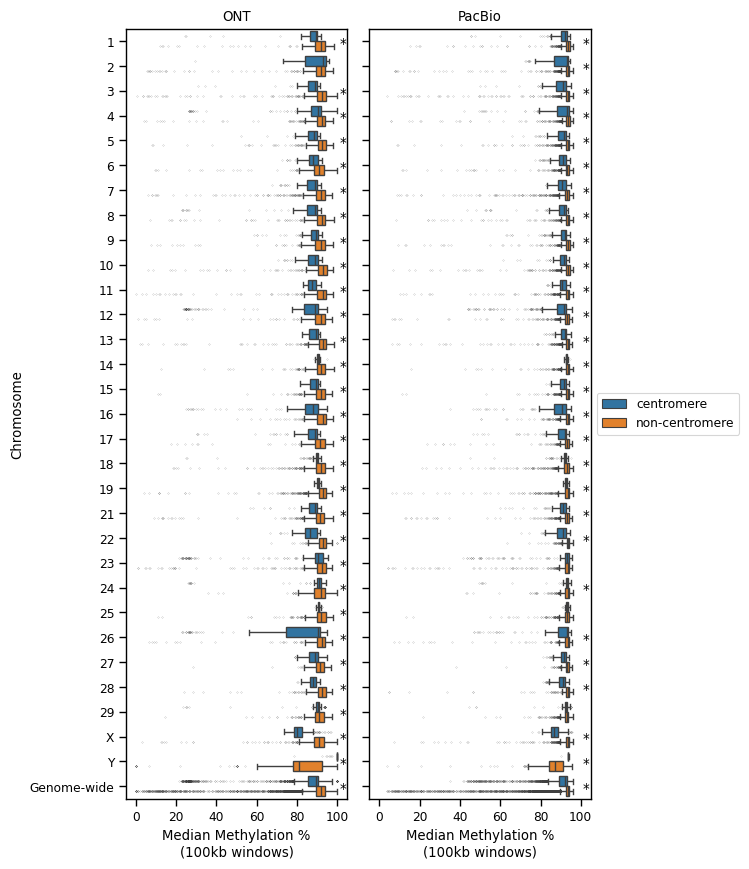

In [ ]:
sns.set_context('paper')
fig, ax = plt.subplots(1, 2, figsize=(6,10), sharey=True, sharex=True)

sns.boxplot(data=plot_df[plot_df['tech'] == 'ONT'],
               x='median_methylation',
               y='chromosome',
               hue='region',
               fliersize=0.1,
               ax=ax[0],
               legend=False)

star_spacing = 0.25

for n, i in enumerate(ax[0].get_yticklabels()):
    if ont_adj_significant[n]:
        ax[0].text(101, i.get_position()[1] + star_spacing, '*')

sns.boxplot(data=plot_df[plot_df['tech'] == 'PacBio'],
                x='median_methylation',
                y='chromosome',
                hue='region',
                fliersize=0.1,
                ax=ax[1])
for n, i in enumerate(ax[0].get_yticklabels()):
    if pb_adj_significant[n]:
        ax[1].text(101, i.get_position()[1] + star_spacing, '*')

plt.subplots_adjust(wspace=0.1)
ax[0].set_title('ONT')
ax[1].set_title('PacBio')
ax[0].set_ylabel('Chromosome')
ax[0].set_xlabel(f'Median Methylation %\n({window} windows)')
ax[1].set_xlabel(f'Median Methylation %\n({window} windows)')
ax[0].set_xlim(-5,105)
ax[1].set_xlim(-5,105)
# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))